In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from datetime import datetime as dt

## Preprocessing

In [ ]:
df = pd.read_csv('DAYTON_hourly.csv',parse_dates={"timestamp":[0]})
# Dropping duplicates
df.drop_duplicates(inplace=True)
# putting timestamp in ascending order
df.sort_values("timestamp",ascending = True,inplace = True)
df.reset_index(drop = True,inplace =True)
df.head()

,timestamp,DAYTON_MW
0,2004-10-01 01:00:00,1621.0
1,2004-10-01 02:00:00,1536.0
2,2004-10-01 03:00:00,1500.0
3,2004-10-01 04:00:00,1434.0
4,2004-10-01 05:00:00,1489.0


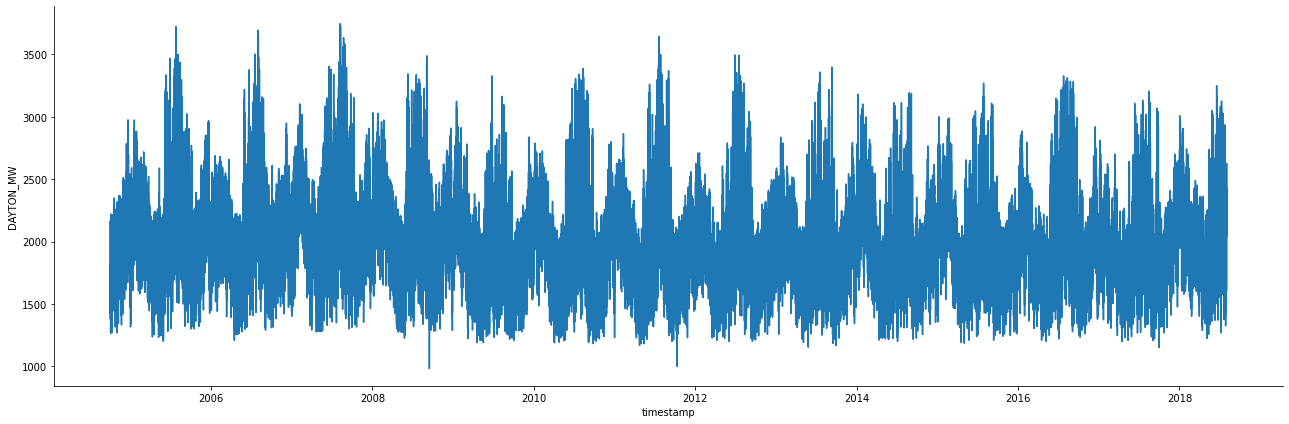

In [ ]:
sns.relplot(
    data=df, 
    x="timestamp", y="DAYTON_MW",
    kind="line",
    height=6, aspect=3 
)

### Observation
We have data from 1 October, 2004 to 03 August, 2018. We can use training data from 2004-2014 and can test on 2014-2018. As we have hourly power consumption data. Hence we have 24 readings in a day.  


In [ ]:
df['year'] = pd.to_numeric(df['timestamp'].dt.strftime('%Y'))
test = df.loc[ df.year > 2014]
train = df.loc[df.year <= 2014]
train.drop(columns = ['year'],inplace = True)
# As the day 1 has 23 timestamps we will exclude it
train = train[23:89835]

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,



###Problem - Given historical data of power consumption(previous 24 hours), forecast power consumption of next hour 

In [ ]:
def split_sequence(sequence, time_steps):
  X, y = list(),list ()
  for i in range(len(sequence)):
    # find the end of the pattern of time_steps
    end_i = i + time_steps
    # check if we are beyond the sequence
    if end_i > len(sequence)-1:    
      break
    seq_x, seq_y = sequence[i:end_i], sequence[end_i]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)


# split into samples
sequence = train['DAYTON_MW'].values
time_steps = 24
X, y = split_sequence(sequence, time_steps)

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [ ]:
from keras.models import Sequential 
from keras.layers import LSTM
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils 
import tensorflow as tf
from keras.layers import Dropout,BatchNormalization, Dense, Activation 
initializer = tf.keras.initializers.HeNormal(seed =10)

In [ ]:
# define model
model = Sequential()
model.add(LSTM(45, activation='relu', input_shape=(time_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# fit model
model.fit(X, y, epochs=12, batch_size = 168,shuffle = False,verbose = 2)

Epoch 1/12
535/535 - 9s - loss: 630551.5000 - 9s/epoch - 17ms/step
Epoch 2/12
535/535 - 8s - loss: 150760.5938 - 8s/epoch - 15ms/step
Epoch 3/12
535/535 - 8s - loss: 100177.5000 - 8s/epoch - 15ms/step
Epoch 4/12
535/535 - 8s - loss: 95849.5234 - 8s/epoch - 15ms/step
Epoch 5/12
535/535 - 8s - loss: 56943.7266 - 8s/epoch - 15ms/step
Epoch 6/12
535/535 - 8s - loss: 40611.6094 - 8s/epoch - 15ms/step
Epoch 7/12
535/535 - 8s - loss: 37742.3516 - 8s/epoch - 15ms/step
Epoch 8/12
535/535 - 8s - loss: 28793.6875 - 8s/epoch - 14ms/step
Epoch 9/12
535/535 - 8s - loss: 27007.0703 - 8s/epoch - 14ms/step
Epoch 10/12
535/535 - 8s - loss: 26057.6406 - 8s/epoch - 14ms/step
Epoch 11/12
535/535 - 8s - loss: 39937.1211 - 8s/epoch - 15ms/step
Epoch 12/12
535/535 - 8s - loss: 19888.5801 - 8s/epoch - 15ms/step


### Evaluate model on test

In [ ]:
# split into samples
sequence = test['DAYTON_MW'].values
X_test, y_test = split_sequence(sequence, time_steps)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
# Evaluate model on test
model.evaluate(X_test,y_test,batch_size=168,verbose =1)

187/187 [==============================] - 2s 7ms/step - loss: 16715.1309


16715.130859375

In [ ]:
predicted = []
for i in range(len(X_test)):
  x_input = X_test[i].reshape((1, time_steps, n_features))
  pred = float(model.predict(x_input))
  predicted.append(pred)

# Grid Search

In [ ]:
model = Sequential()
model.add(LSTM(45, activation='relu', input_shape=(time_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

units,activation,kernel_initializer,inputs = [batch,time_steps,n_features]
model = sequential()


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import initializers
from keras.wrappers.scikit_learn import KerasClassifier
time_steps = 24
n_features = 1
# Define model
def create_model():
  model = Sequential()
  model.add(LSTM(units=units, activation=activation, inputs=[batch_size,24,1])
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  return model
# Determine the hyperparameter space
param_grid = dict(
    units=[20, 30, 45, 50],
    activation=['relu','elu','selu','tanh'],
    kernel_initializer=['HeNormal','HeUniform'],
    batch_size = [125, 168, 200, 300]
    )


## Plot daily consumption

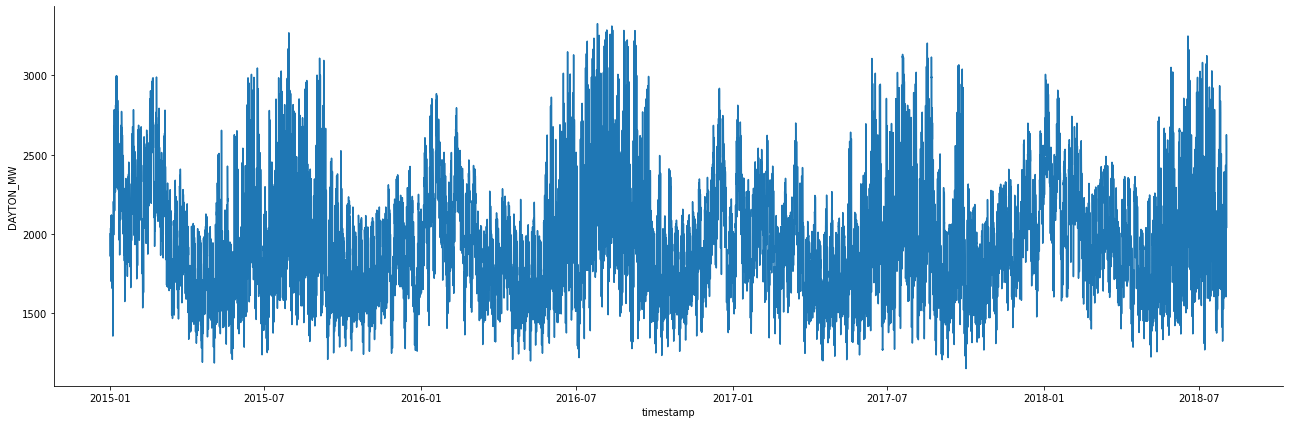

In [ ]:
sns.relplot(
    data=test, 
    x="timestamp", y="DAYTON_MW",
    kind="line",
    height=6, aspect=3 
)

## Plot predicted consumption

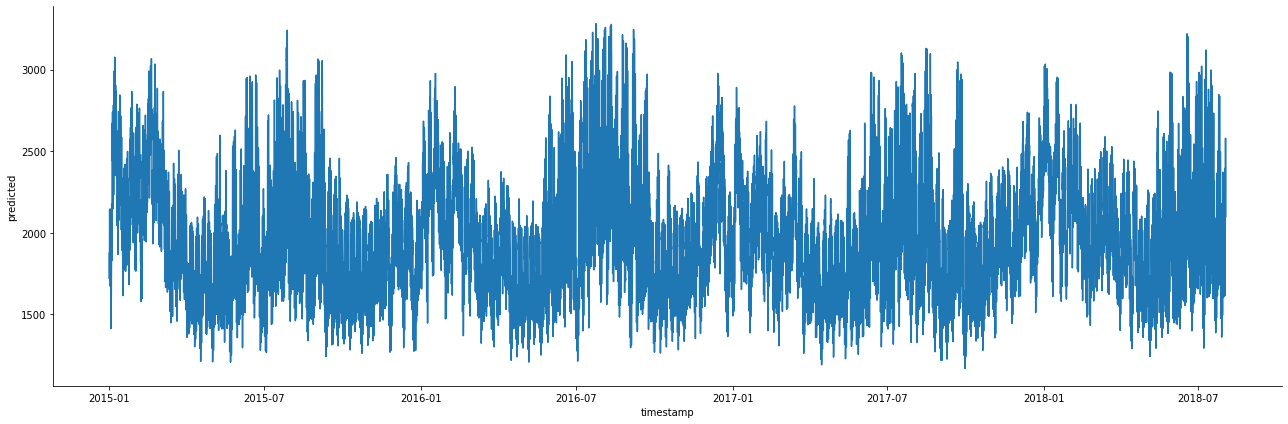

In [ ]:
test = test[0:31416] 
test["predicted"] = predicted
sns.relplot(
    data=test, 
    x="timestamp", y="predicted",
    kind="line",
    height=6, aspect=3 
)